In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-884852549.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [4]:
import numpy as np
import tensorflow as tf
from collections import Counter

# X, y dtype/shape 점검 및 형 변환
X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
testX   = testX.astype('float32')

num_timesteps = X_train.shape[1]   # 보통 128
num_features  = X_train.shape[2]   # 보통 9
num_classes   = y_train_one_hot.shape[1]  # 보통 6

print(f"timesteps={num_timesteps}, features={num_features}, classes={num_classes}")
print("y_train 분포:", Counter(y_train.flatten()))
print("y_val   분포:", Counter(y_val.flatten()))

# 재현성(선택)
seed = 100
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)


timesteps=128, features=9, classes=6
y_train 분포: Counter({np.int64(5): 1116, np.int64(4): 1093, np.int64(3): 1040, np.int64(0): 983, np.int64(1): 870, np.int64(2): 779})
y_val   분포: Counter({np.int64(5): 291, np.int64(4): 281, np.int64(3): 246, np.int64(0): 243, np.int64(2): 207, np.int64(1): 203})


In [5]:
from tensorflow.keras import layers, models, callbacks, optimizers

def build_lstm_model(timesteps, features, classes, lstm_units=64, dense_units=64, dropout_rate=0.3):
    inputs = layers.Input(shape=(timesteps, features))
    x = layers.LSTM(lstm_units, return_sequences=True)(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.LSTM(lstm_units)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_lstm_model(num_timesteps, num_features, num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 64)        │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,030 (222.77 KB)

 Trainable params: 56,774 (221.77 KB)

 Non-trainable params: 256 (1.00 KB)

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 클래스 가중치 (불균형 있을 때 권장)
classes = np.arange(num_classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train.flatten()
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("class_weight:", class_weight_dict)

es = callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True
)
rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5
)
ckpt = callbacks.ModelCheckpoint(
    'best_lstm.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)


class_weight: {0: np.float64(0.9971176670057647), 1: np.float64(1.1266283524904215), 2: np.float64(1.258237056054771), 3: np.float64(0.9424679487179487), 4: np.float64(0.896767307105825), 5: np.float64(0.8782855436081243)}


In [15]:
history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=30,
    batch_size=64,
    callbacks=[es, rlr, ckpt],
    class_weight=class_weight_dict  # 불균형 크지 않다면 제거해도 됩니다.
)


Epoch 1/30
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9511 - loss: 0.1063
Epoch 1: val_accuracy did not improve from 0.95241
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9512 - loss: 0.1061 - val_accuracy: 0.9517 - val_loss: 0.1225 - learning_rate: 2.5000e-04
Epoch 2/30
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9485 - loss: 0.1110
Epoch 2: val_accuracy did not improve from 0.95241
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9486 - loss: 0.1108 - val_accuracy: 0.9436 - val_loss: 0.1412 - learning_rate: 2.5000e-04
Epoch 3/30
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9525 - loss: 0.1123
Epoch 3: val_accuracy did not improve from 0.95241
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9527 - loss: 0.1118 - val_accuracy: 0.9511 - val_loss: 0.1176 - learning_rate: 2.5000e-04
Epoch 4/30
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9489 - loss: 0.1122
Epoch 4: val_accuracy did not improve from 0.95241
92/92 ━━━━━━━━━━━━━━━━━━

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9504 - loss: 0.1078 - val_accuracy: 0.9538 - val_loss: 0.1140 - learning_rate: 2.5000e-04
Epoch 7/30
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9510 - loss: 0.1085
Epoch 7: val_accuracy did not improve from 0.95377
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9511 - loss: 0.1081 - val_accuracy: 0.9524 - val_loss: 0.1164 - learning_rate: 2.5000e-04
Epoch 8/30
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9543 - loss: 0.1046
Epoch 8: val_accuracy did not improve from 0.95377
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9544 - loss: 0.1041 - val_accuracy: 0.9531 - val_loss: 0.1154 - learning_rate: 2.5000e-04
Epoch 9/30
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9525 - loss: 0.1073
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 9: val_accuracy did not improve from 0.95377
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9527 - loss: 0.1069 - val_acc

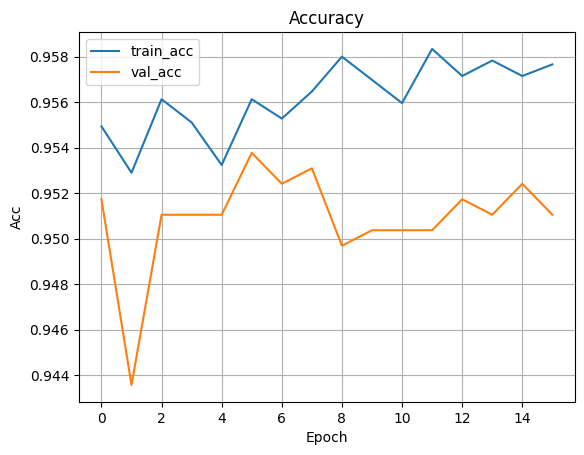

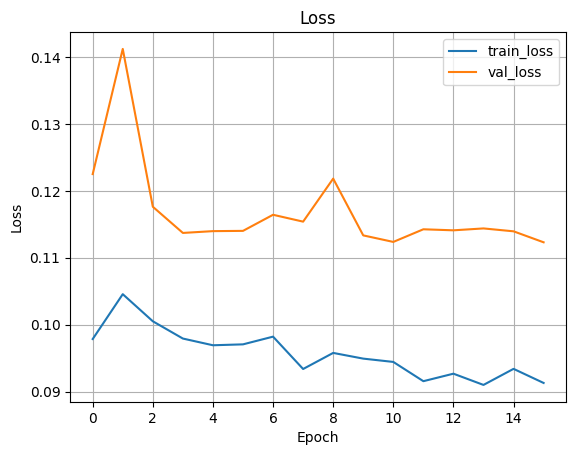

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
plt.show()


[VAL] loss=0.1140, acc=0.9538
[TEST] loss=0.3018, acc=0.9213

[VAL] Classification Report
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       243
           1     0.9951    0.9951    0.9951       203
           2     1.0000    1.0000    1.0000       207
           3     0.8532    0.8740    0.8635       246
           4     0.8909    0.8719    0.8813       281
           5     1.0000    1.0000    1.0000       291

    accuracy                         0.9538      1471
   macro avg     0.9565    0.9568    0.9566      1471
weighted avg     0.9539    0.9538    0.9538      1471



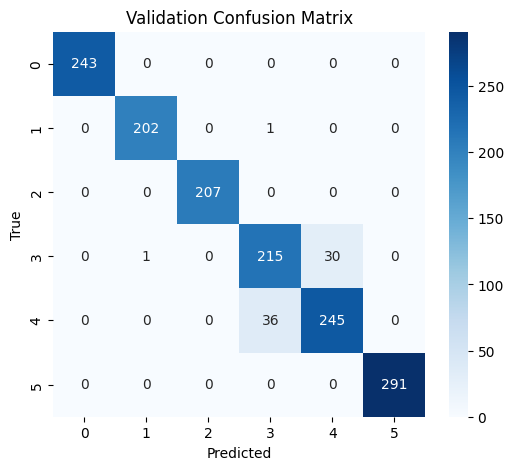

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 최고 성능 가중치 로드(선택)
model.load_weights('best_lstm.h5')

# 검증 성능
val_loss, val_acc = model.evaluate(X_val, y_val_one_hot, verbose=0)
print(f"[VAL] loss={val_loss:.4f}, acc={val_acc:.4f}")

# 테스트 성능
test_loss, test_acc = model.evaluate(testX, testy_one_hot, verbose=0)
print(f"[TEST] loss={test_loss:.4f}, acc={test_acc:.4f}")

# 예측 → 리포트/혼동행렬
val_pred = model.predict(X_val, verbose=0)
val_pred_label = np.argmax(val_pred, axis=1)

print("\n[VAL] Classification Report")
print(classification_report(y_val.flatten(), val_pred_label, digits=4))

cm = confusion_matrix(y_val.flatten(), val_pred_label)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()
